# **IDENTIFIKASI KEMATANGAN PADA BUAH SAWIT**
by michael

Link PPT Presentasi Proyek:<br>
https://docs.google.com/presentation/d/1Pd0qPXRkBCkzfEpeSoXfNgE1aFH8e8__/edit?usp=sharing&ouid=102940030729483818531&rtpof=true&sd=true

Link Google Drive Dataset:<br>
https://drive.google.com/drive/folders/1HOfK5sH9PNG-I21ZxPCKT6hGkxosmuLY?usp=sharing

`import library`

In [ ]:
# Additional library
import os
import PIL
import cv2
import time
import scipy
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from scipy import interp

# Plotting graph
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display
from itertools import cycle

# Image processing
from PIL import Image

# Model library
import keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
from keras import applications
from keras.models import Sequential
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D,Dropout

# Evaluation matrics library
from sklearn import metrics, svm, datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

sns.set(style='whitegrid')

# **Read Data**

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/project/PORTODATA/JSC/dataset/'
os.chdir(path)
print(os.getcwd())
!ls

/content/drive/MyDrive/project/PORTODATA/JSC/dataset
sawit_matang  sawit_mentah


`menentukan setiap subdirectory :`

In [ ]:
# Folder Sawit Matang
matang_dir = os.path.join('sawit_matang') 

# Folder Sawit Mentah
mentah_dir = os.path.join('sawit_mentah')

`check file pada directory buah sawit matang dan mentah :`

In [ ]:
matang_file = os.listdir(matang_dir)
print(matang_file[:5])

mentah_file = os.listdir(mentah_dir)
print(mentah_file[:5])

# Total Gambar
print('total data gambar sawit matang :', len(matang_file))
print('total data gambar sawit mentah :', len(mentah_file))

['IMG20220331130802.jpg', 'IMG20220331131259.jpg', 'IMG20220331130843.jpg', 'IMG20220331130806.jpg', 'IMG20220331130811.jpg']
['IMG20220331094439.jpg', 'IMG20220331094438.jpg', 'IMG20220331094414.jpg', 'IMG20220331094351.jpg', 'IMG20220331094418.jpg']
total data gambar sawit matang : 202
total data gambar sawit mentah : 291


# **Data Preparation**

`melihat beberapa gambar untuk mendapatkan sense lebih baik`

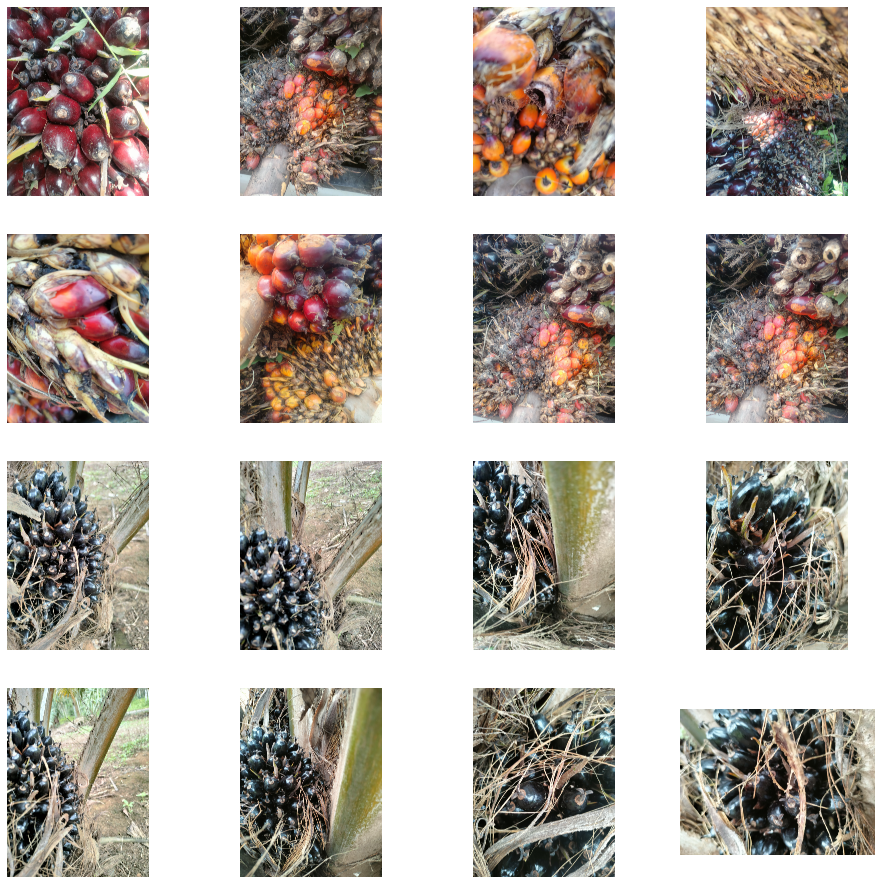

In [ ]:
%matplotlib inline

nrows = 4
ncols = 4
pic_index = 0

# Setup matplotlib fig dan size fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_matang_pic = [os.path.join(matang_dir, fname) 
                for fname in matang_file[pic_index-8:pic_index]]
next_mentah_pic = [os.path.join(mentah_dir, fname) 
                for fname in mentah_file[pic_index-8:pic_index]]

for i, img_path in enumerate(next_matang_pic + next_mentah_pic):
  # Setup subplot
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Splitting dataset

In [ ]:
# install library split-folders
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


`membuat folder baru`

In [ ]:
# Import module splitfolders
import splitfolders
os.chdir('/content/drive/MyDrive/project/PORTODATA/JSC/')

# Membuat folder untuk menyimpan dataset yang telah di split
!mkdir split-dataset
!ls

mkdir: cannot create directory ‘split-dataset’: File exists
 coding_imageclassification_michael.ipynb
 dataset
 model_kematangan_sawit.h5
 model.png
'Presentation_Michael Yulius Sitanggang.pptx'
'Salinan coding_imageclassification_michael.ipynb'
 split-dataset


`membagi data dengan rasio train:80% dan valid:20%`

In [ ]:
splitfolders.ratio('dataset', output="split-dataset", seed=1337, ratio=(0.8,0.2), group_prefix=None)

Copying files: 493 files [00:53,  9.27 files/s]


## `Image Data Generator` **Augmentation**

In [ ]:
path_train = 'split-dataset/train/'
path_val = 'split-dataset/val/'

In [ ]:
# Load object ImageDataGenerator
train_datagen = ImageDataGenerator( rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range=0.2)

# Load dataset dan lakukan random augmentation menggunakan flow_from_directory
train_generator = train_datagen.flow_from_directory(path_train,
                                                 target_size=(128,128),
                                                 color_mode="rgb",
                                                 shuffle=False,
                                                 batch_size = 64,
                                                 class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(path_val,
                                               target_size=(128,128),
                                               color_mode="rgb",
                                               shuffle=False,
                                               batch_size = 64,
                                               class_mode='categorical')

Found 393 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


# **Model Definition**

In [ ]:
model = Sequential()

# Conv Layer pertama
model.add(Conv2D(64, (3,3), activation = 'relu', input_shape=(128,128, 3)))
model.add(MaxPooling2D(2,2))

# Conv Layer kedua
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))

# Conv Layer ketiga
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))

# Conv Layer keempat
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))

# Flatten
model.add(Flatten()) #membuat ukuran 1 Dimensi, misal 8*8 menjadi 1*64
model.add(Dropout(0.5))

# Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 64)      

`Visualisasi Model`

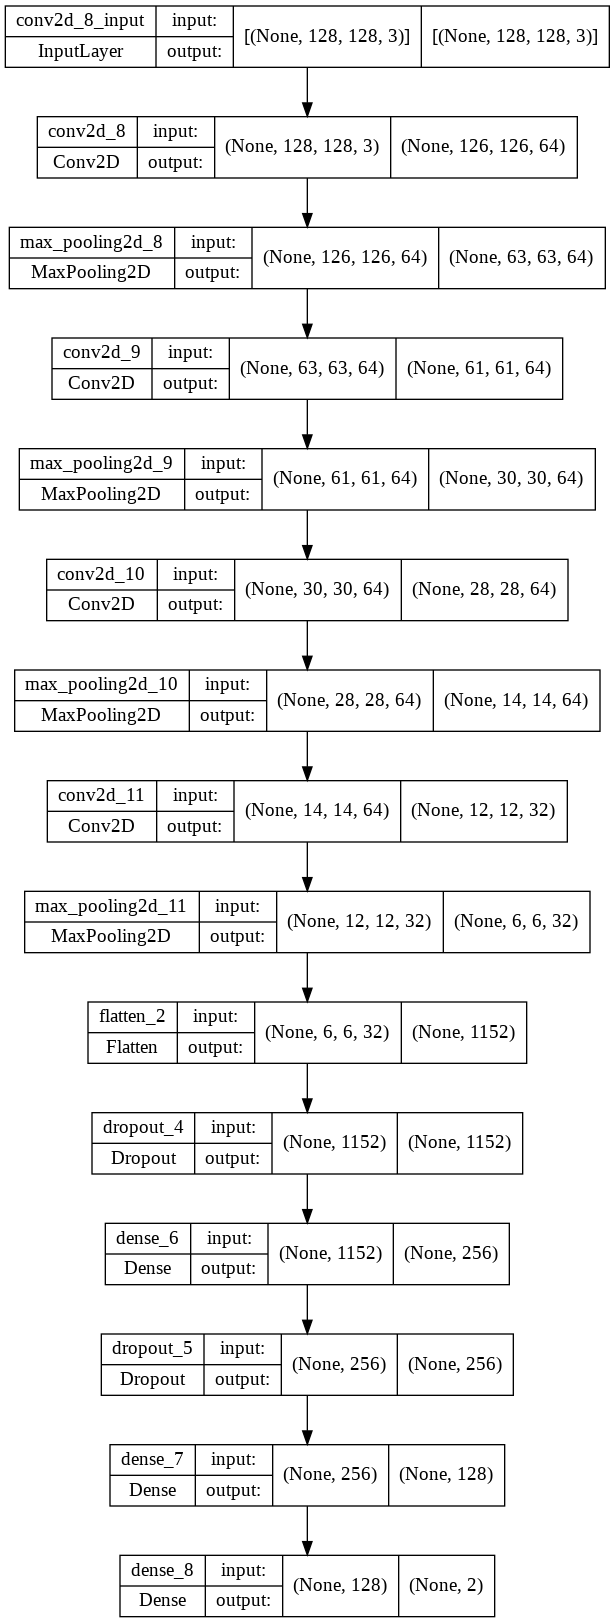

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    expand_nested=False,
    dpi=96,
)

`Compile Model`

In [ ]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

# `Training Model`

In [ ]:
start_time = time.time() 


history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator
                    #  callbacks=earlystop
                    )

stop_time = time.time() 

Epoch 1/10
7/7 [==============================] - 186s 27s/step - loss: 0.8680 - accuracy: 0.5242 - val_loss: 0.6793 - val_accuracy: 0.5900
Epoch 2/10
7/7 [==============================] - 155s 23s/step - loss: 0.6737 - accuracy: 0.5903 - val_loss: 0.6850 - val_accuracy: 0.5900
Epoch 3/10
7/7 [==============================] - 155s 22s/step - loss: 0.6971 - accuracy: 0.5903 - val_loss: 0.6879 - val_accuracy: 0.5900
Epoch 4/10
7/7 [==============================] - 156s 22s/step - loss: 0.6867 - accuracy: 0.5903 - val_loss: 0.6835 - val_accuracy: 0.5900
Epoch 5/10
7/7 [==============================] - 167s 24s/step - loss: 0.6970 - accuracy: 0.5903 - val_loss: 0.6732 - val_accuracy: 0.5900
Epoch 6/10
7/7 [==============================] - 153s 22s/step - loss: 0.6758 - accuracy: 0.5903 - val_loss: 0.6643 - val_accuracy: 0.5900
Epoch 7/10
7/7 [==============================] - 153s 22s/step - loss: 0.7564 - accuracy: 0.5903 - val_loss: 0.6645 - val_accuracy: 0.5900
Epoch 8/10
7/7 [====

`waktu training model`

In [ ]:
print('Runtime training model: %.2fs' % (stop_time - start_time))

Runtime training model: 1864.94s


`visualisasi model accuracy dan model loss`

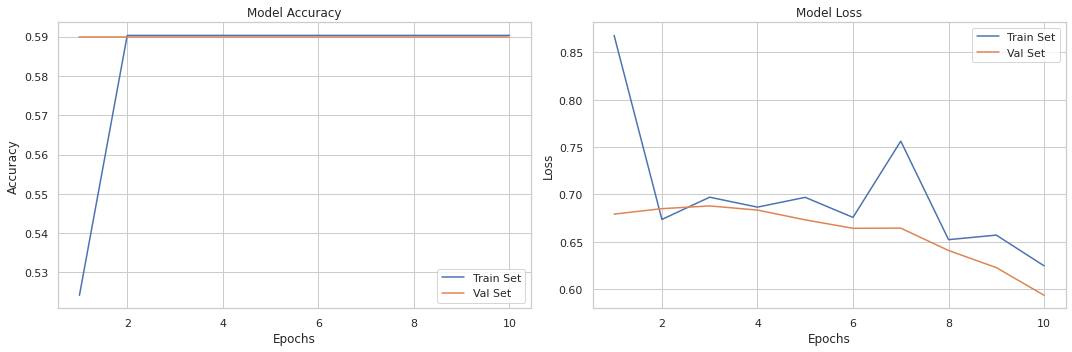

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

`perhitungan model accuracy dan model loss`

In [ ]:
xtr, ytr = zip(*(train_generator[i] for i in range(len(train_generator))))
x_train, y_train = np.vstack(xtr), np.vstack(ytr)

xvs, yvs = zip(*(validation_generator[i] for i in range(len(validation_generator))))
x_val, y_val = np.vstack(xvs), np.vstack(yvs)

train_loss, train_acc = model.evaluate(x_train, y_train)
val_loss, val_acc = model.evaluate(x_val, y_val)

print('Train accuracy:', train_acc)
print('Train loss:', train_loss)
print('Val accuracy:', val_acc)
print('Val loss:', val_loss)

4/4 [==============================] - 2s 413ms/step - loss: 0.5935 - accuracy: 0.5900
Train accuracy: 0.5903307795524597
Train loss: 0.584370493888855
Val accuracy: 0.5899999737739563
Val loss: 0.5935443043708801


# `Model Evaluation`

In [ ]:
model.evaluate(validation_generator)

2/2 [==============================] - 29s 11s/step - loss: 0.5944 - accuracy: 0.5900


[0.594377875328064, 0.5899999737739563]

In [ ]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()

preds = model.predict(validation_generator,
                      verbose=1)[:, 1] 

2/2 [==============================] - 30s 10s/step


`membuat ROC curve dan AUC, menghitung false-positive rate dan true-positive rate`

In [ ]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)
roc_auc = auc(fpr, tpr)

`visualisasi ROC curve`

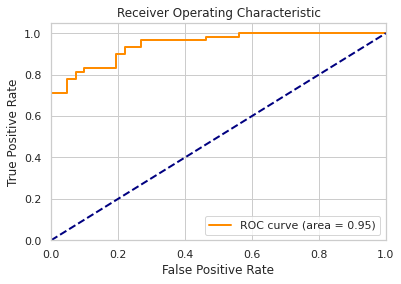

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

ROC memiliki tingkat nilai diagnosa yaitu: 

* `0,90 - 1,00 = excellent classification`
* 0,80 - 0,90 = good classification
* 0,70 - 0,80 = fair classification
* 0,60 - 0,70 = poor classification
* 0,50 - 0,60 = failure classification

Berdasarkan klasifikasi tersebut maka dapat disimpulkan bahwa `model termasuk dalam excellent classification` untuk melakukan klasifikasi buah sawit matang dan mentah.

`menyimpan model`

In [ ]:
model.save('model_kematangan_sawit.h5')

# `Prediction`

Saving 14.jpg to 14.jpg
[1.]
14.jpg ini adalah buah sawit yang belum matang


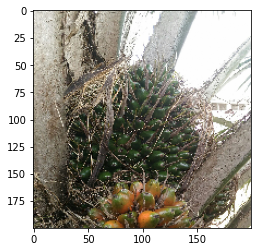

In [ ]:
%matplotlib inline
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(128, 128))
  x = image.img_to_array(img)
  plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]<0.5:
    print(fn + " ini adalah buah sawit yang sudah matang")
  else:
    print(fn + " ini adalah buah sawit yang belum matang")

Hasil = *Prediksi Benar*